In [ ]:
import os
import shutil
import random
from pathlib import Path

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNet

In [ ]:
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  ax1.plot(epochs_range, acc, label='Training Accuracy')
  ax1.plot(epochs_range, val_acc, label='Validation Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.set_title('Training and Validation Accuracy')
  ax1.legend()

  ax2.plot(epochs_range, loss, label='Training Loss')
  ax2.plot(epochs_range, val_loss, label='Validation Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.set_title('Training and Validation Loss')
  ax2.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
# garbage
# https://drive.usercontent.google.com/download?id=1UAY-YMWxlMZczYWuOesP4XIJERCCEE3F&export=download&authuser=0&confirm=t&uuid=19ef193d-2d27-440d-8206-163d72c61392&at=AENtkXZnTt0VPwyNCs-0Xiu0yC5-:1732865754893

# 16 class terbaru
# https://drive.usercontent.google.com/download?id=1s2mJ4-ZrzER1H2gyIL2aKwS3tLyiRxCt&export=download&authuser=0&confirm=t&uuid=5fca0042-0f50-4177-8dd1-9d22a485b17a&at=AENtkXYqhoEXRUfFZqzxByf6P6Jn:1732943358020

!wget "https://drive.usercontent.google.com/download?id=1s2mJ4-ZrzER1H2gyIL2aKwS3tLyiRxCt&export=download&authuser=0&confirm=t&uuid=5fca0042-0f50-4177-8dd1-9d22a485b17a&at=AENtkXYqhoEXRUfFZqzxByf6P6Jn:1732943358020" -O trash_data.zip


--2024-12-08 09:59:33--  https://drive.usercontent.google.com/download?id=1s2mJ4-ZrzER1H2gyIL2aKwS3tLyiRxCt&export=download&authuser=0&confirm=t&uuid=5fca0042-0f50-4177-8dd1-9d22a485b17a&at=AENtkXYqhoEXRUfFZqzxByf6P6Jn:1732943358020
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197223270 (188M) [application/octet-stream]
Saving to: ‘trash_data.zip’

trash_data.zip      100%[===================>] 188.09M  30.4MB/s    in 6.2s    

2024-12-08 09:59:41 (30.1 MB/s) - ‘trash_data.zip’ saved [197223270/197223270]



In [ ]:
!unzip -o -q trash_data.zip -d data

In [ ]:
data_dir = './data'
output_dir = './split_data'

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

label = os.listdir(data_dir)
print(label)

['rag', 'cans', 'spoonfork', 'cardboard', 'plasticbottle', 'glassbottle', 'plasticbag', 'paper', 'watergallon', 'newspaper', 'ceramicsbowl', 'bottlecap', 'pen', 'tire', 'galvanizedsteel', 'disc']


In [ ]:
# Buat folder untuk split dataset
Path(output_dir).mkdir(parents=True, exist_ok=True)
for split in ['train', 'val', 'test']:
    (Path(output_dir) / split).mkdir(parents=True, exist_ok=True)

In [ ]:
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)  # misal ./data/ada_class
    if not os.path.isdir(class_dir):
        continue

    for split in ['train', 'val', 'test']:
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    random.shuffle(images)

    train_count = int(len(images) * train_ratio)
    val_count = int(len(images) * val_ratio)
    test_count = len(images) - train_count - val_count

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Salin gambar ke folder split masing-masing
    for img in train_images:
        shutil.copy(img, os.path.join(output_dir, 'train', class_name))
    for img in val_images:
        shutil.copy(img, os.path.join(output_dir, 'val', class_name))
    for img in test_images:
        shutil.copy(img, os.path.join(output_dir, 'test', class_name))

print("Dataset berhasil dibagi!")

Dataset berhasil dibagi!


In [ ]:
data_dir = './split_data'

# Parameter dataset
image_size = (224, 224)
batch_size = 32

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/train',
    labels='inferred',
    label_mode='categorical',  # Menggunakan one-hot encoding
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/val',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=f'{data_dir}/test',
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False  # Tidak perlu diacak
)

# Periksa struktur dataset
print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)
print("Test Dataset:", test_dataset)

Found 10167 files belonging to 16 classes.
Found 2008 files belonging to 16 classes.
Found 2040 files belonging to 16 classes.
Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>
Test Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>


In [ ]:
# def augment_image(image):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
#     image = tf.image.random_brightness(image, max_delta=0.1)
#     image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
#     return image

# def augment_dataset(dataset):
#     return dataset.map(
#         lambda x, y: (augment_image(x), y),
#         num_parallel_calls=tf.data.AUTOTUNE
#     )

# augmented_train_set = augment_dataset(train_dataset)

In [25]:
train_dataset_final = train_dataset.cache().shuffle(
    1000,
    reshuffle_each_iteration=True
).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset_final = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset_final = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
    layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
    layers.RandomZoom(0.2, fill_mode="nearest"),
    layers.RandomBrightness(0.2),
    layers.RandomRotation(0.2, fill_mode="nearest"),
    layers.RandomContrast(0.2),
])

# Contoh gambar input
image = tf.random.uniform(shape=(1, 224, 224, 3))
#
# Menghasilkan 5 versi augmentasi
augmented_images = [data_augmentation(image) for _ in range(5)]

In [53]:
models = tf.keras.models
layers = tf.keras.layers

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

model = models.Sequential([

    # Augmentasi yang lebih agresif
    # tf.keras.Input(shape=(224, 224, 3)),
    # layers.RandomFlip("horizontal_and_vertical", input_shape=),
    # layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
    # layers.RandomZoom(0.2, fill_mode="nearest"),
    # layers.RandomBrightness(0.2),
    # layers.RandomRotation(0.2, fill_mode="nearest"),
    # layers.RandomContrast(0.2),

    # layers.Rescaling(1./255),
    base_model,

    # layers.Conv2D(512, (3, 3), activation="relu"),
    # layers.MaxPooling2D(2, 2),

    # layers.Conv2D(64, (3, 3), activation="relu"),
    # layers.MaxPooling2D(2, 2),

    # layers.Conv2D(128, (3, 3), activation="relu"),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(128, (3, 3), activation="relu"),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(256, (3, 3), activation="relu"),
    # layers.MaxPooling2D(2, 2),

    layers.Flatten(),

    layers.Dense(256, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(label), activation='softmax')


])

model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional)      │ (None, 4, 4, 1024)          │       3,228,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 256)                 │       4,194,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,427,536 (28.33 MB)

 Trainable params: 4,198,672 (16.02 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 * 10**(epoch / 20))

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)

class PrintLearningRate(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Learning rate at epoch {epoch + 1}: {lr}")

In [55]:
history = model.fit(
    train_dataset_final,
    validation_data=val_dataset_final,
    epochs=20,
    verbose=1,

    callbacks=[]

)

Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.3151 - loss: 2.3446 - val_accuracy: 0.5680 - val_loss: 1.3613
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6490 - loss: 1.1122 - val_accuracy: 0.6004 - val_loss: 1.2054
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7556 - loss: 0.7739 - val_accuracy: 0.6546 - val_loss: 1.0715
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8431 - loss: 0.5348 - val_accuracy: 0.6860 - val_loss: 1.0448
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9002 - loss: 0.3735 - val_accuracy: 0.6727 - val_loss: 1.0342
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9362 - loss: 0.2680 - val_accuracy: 0.6851 - val_loss: 1.0153
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9627 - loss: 0.1912 - val_accuracy: 0.6851 - val_loss: 1.0461
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9757 - loss: 0.1354 - val_acc

In [39]:
 loss, accuracy = model.evaluate(test_dataset)
print("Accuracy", accuracy)

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6993 - loss: 1.5948
Accuracy 0.686274528503418


In [ ]:
# model.save("model_96.h5")
model.save("model_96.keras")

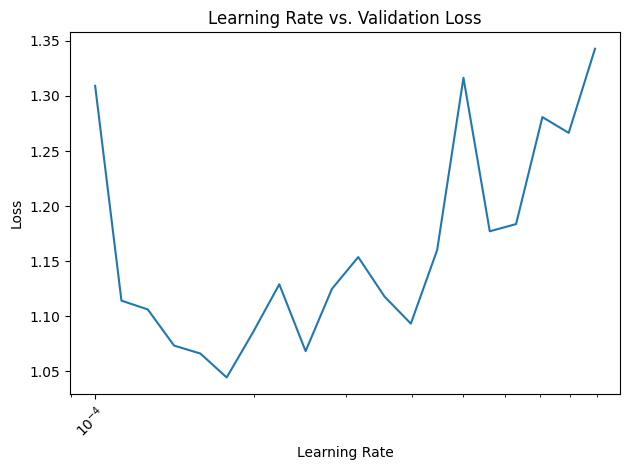

In [32]:
plt.semilogx(history.history['learning_rate'], history.history['val_loss'])
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs. Validation Loss')
plt.tight_layout()

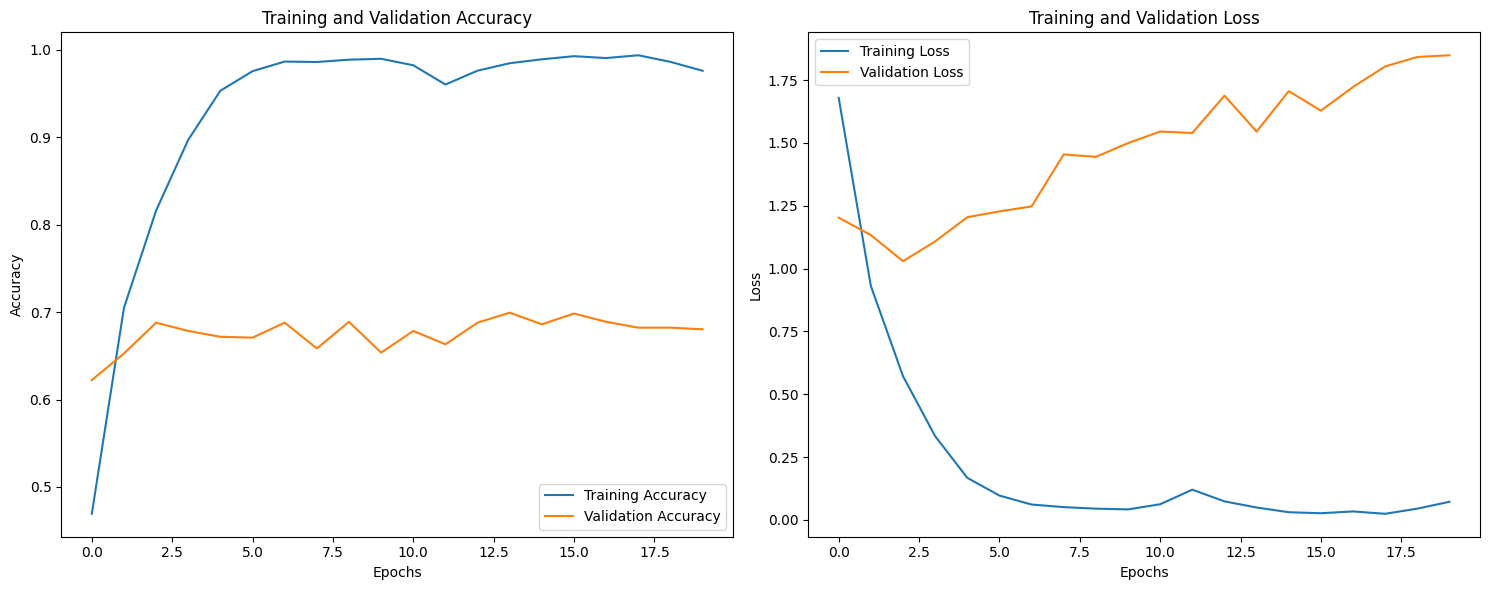

In [48]:
# dataset garbage
plot_loss_acc(history)

['rag', 'cans', 'spoonfork', 'cardboard', 'plasticbottle', 'glassbottle', 'plasticbag', 'paper', 'watergallon', 'newspaper', 'ceramicsbowl', 'bottlecap', 'pen', 'tire', 'galvanizedsteel', 'disc']
(32, 16)
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step


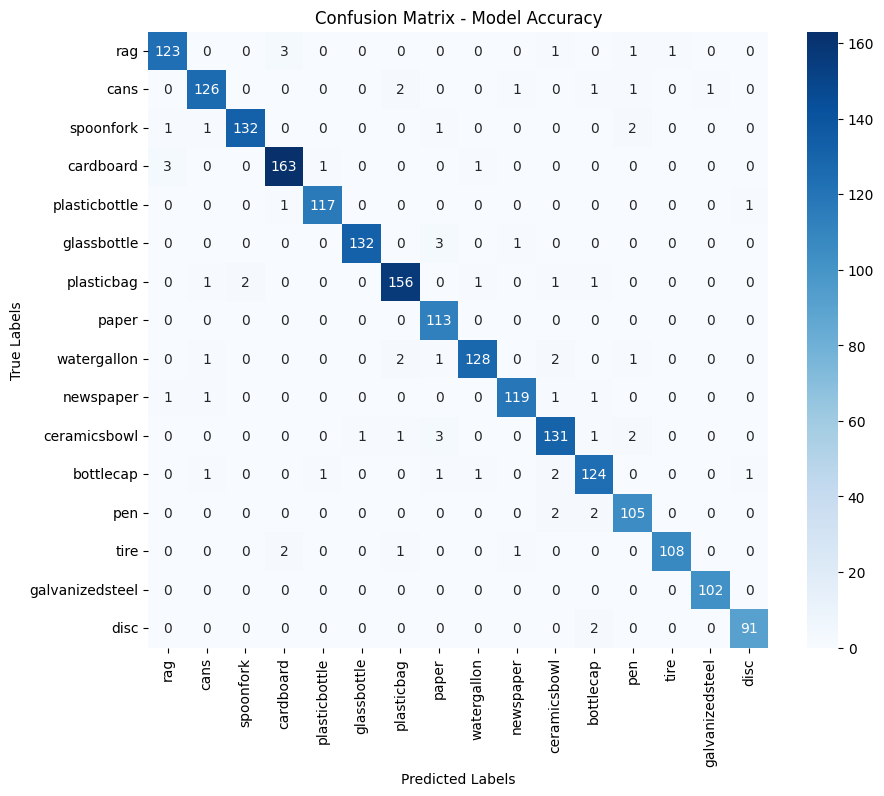

In [ ]:

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

x, y = test_dataset_final.as_numpy_iterator().next()
print(label)
print(y.shape)

y_true = np.argmax(np.concatenate([y for x, y in test_dataset_final]), axis=1)  # Assuming categorical labels
# print(y_true)
predictions = model.predict(test_dataset_final)
y_pred = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label, yticklabels=label)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Model Accuracy')
plt.show()



In [ ]:
# prompt: menampilkan report dari predict di atas misalkan precisionnya berapa per class

from sklearn.metrics import classification_report
from tabulate import tabulate

y_true = np.argmax(np.concatenate([y for x, y in test_dataset_final]), axis=1)
predictions = model.predict(test_dataset_final)
y_pred = np.argmax(predictions, axis=1)

data_dir_buat_plot = './data'
label = os.listdir(data_dir_buat_plot)
print(label)

# Buat classification report
report_dict = classification_report(y_true, y_pred, target_names=label, zero_division=1, output_dict=True)
report_df = pd.DataFrame(report_dict).T

# Cetak report dengan format tabel
print(tabulate(report_df, headers='keys', tablefmt='pipe'))

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
['rag', 'cans', 'spoonfork', 'cardboard', 'plasticbottle', 'glassbottle', 'plasticbag', 'paper', 'watergallon', 'newspaper', 'ceramicsbowl', 'bottlecap', 'pen', 'tire', 'galvanizedsteel', 'disc']
|                 |   precision |   recall |   f1-score |     support |
|:----------------|------------:|---------:|-----------:|------------:|
| rag             |    0.960938 | 0.953488 |   0.957198 |  129        |
| cans            |    0.961832 | 0.954545 |   0.958175 |  132        |
| spoonfork       |    0.985075 | 0.963504 |   0.97417  |  137        |
| cardboard       |    0.964497 | 0.970238 |   0.967359 |  168        |
| plasticbottle   |    0.983193 | 0.983193 |   0.983193 |  119        |
| glassbottle     |    0.992481 | 0.970588 |   0.981413 |  136        |
| plasticbag      |    0.962963 | 0.962963 |   0.962963 |  162        |
| paper           |    0.92623  | 1        |   0.961702 |  113        |
| watergallon     |    0.977099 | 0.948148 |

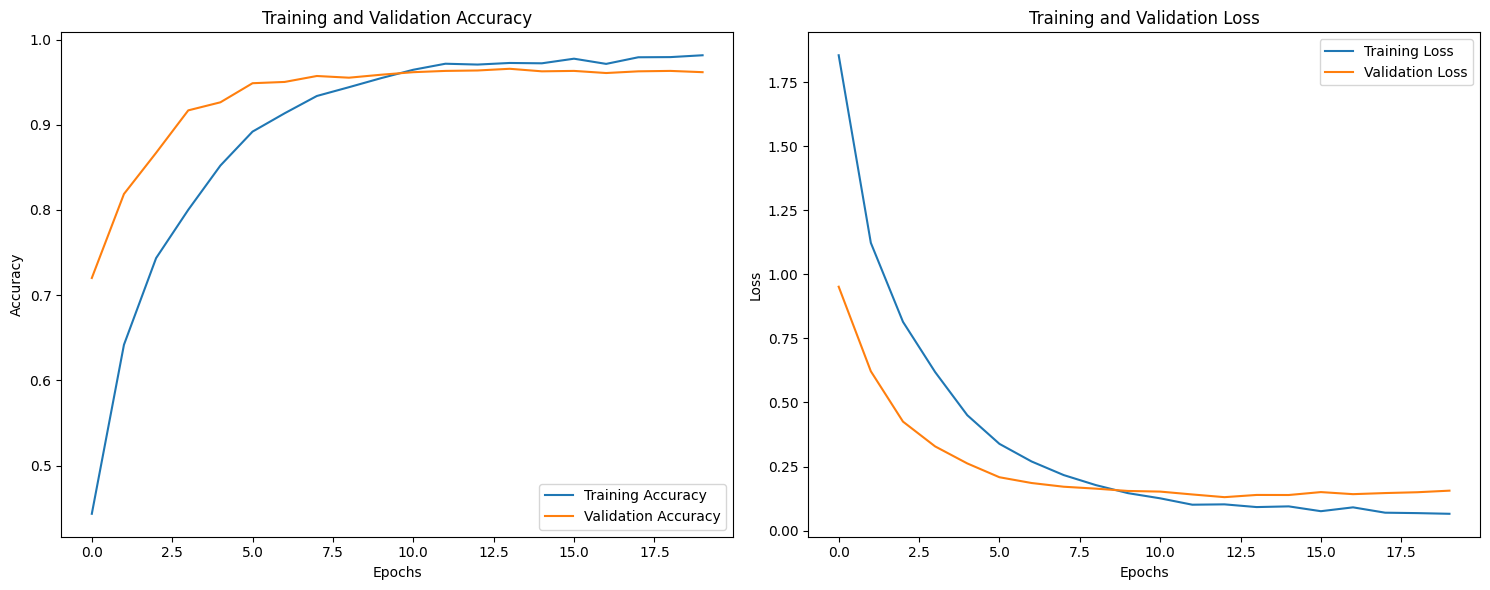

In [ ]:
# dataset garbage
plot_loss_acc(history)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !cp model_96.h5 /content/drive/MyDrive/dataset_capstone_bangkit/
!cp model_96.keras /content/drive/MyDrive/dataset_capstone_bangkit/

In [ ]:
!pip install gradio

import gradio as gr
import tensorflow as tf
import numpy as np
from PIL import Image

# Muat model yang sudah dilatih (pastikan path sesuai dengan lokasi model Anda di Colab)
model = tf.keras.models.load_model('/content/trained_cnn_model.h5')

# Fungsi untuk melakukan prediksi
def predict_image(input_image):
    # Ubah ukuran gambar sesuai input model (misalnya 224x224)
    image = Image.fromarray(input_image).resize((224, 224))

    # Konversi ke array NumPy dan normalisasi
    image_array = np.array(image) / 255.0

    # Tambahkan dimensi batch
    image_array = np.expand_dims(image_array, axis=0)

    # Lakukan prediksi
    prediction = model.predict(image_array)

    # Dapatkan label dengan probabilitas tertinggi
    # Sesuaikan dengan label kelas di model Anda
    class_labels = ['kelas1', 'kelas2', 'kelas3']  # Ganti dengan label aktual Anda
    predicted_class = class_labels[np.argmax(prediction)]

    # Kembalikan nama kelas dan probabilitas
    return f"Prediksi: {predicted_class} (Probabilitas: {prediction[0][np.argmax(prediction)]*100:.2f}%)"

# Buat antarmuka Gradio
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),  # Menerima input gambar
    outputs=gr.Textbox(),  # Menampilkan hasil prediksi
    title="Prediksi Gambar dengan Model CNN",
    description="Unggah gambar untuk diprediksi"
)

# Jalankan antarmuka
interface.launch(debug=True)

In [ ]:
# catatan : data_garbage 32 64 64 | flat | 128 | augmentasi cuma 2 lr = 0.002
# data_garbage 32 64 64 | flat | 128 | augment cuma 4 lr adam 0.000465

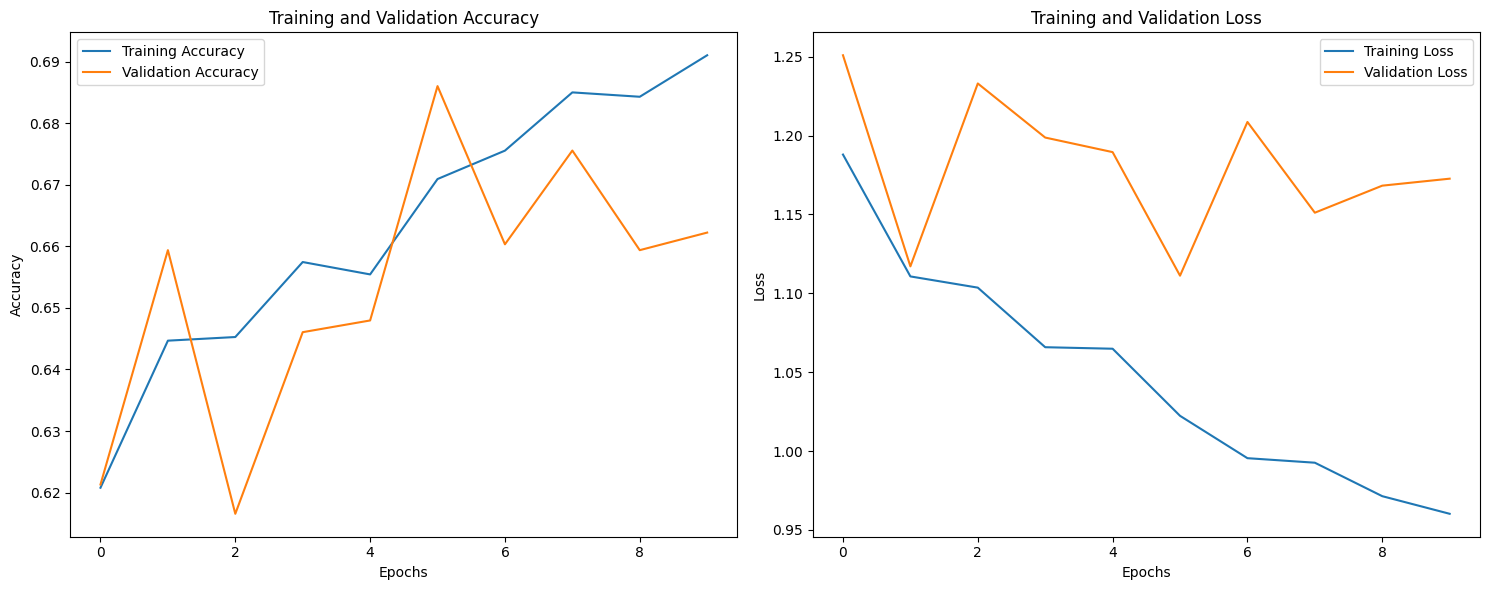

In [ ]:
# sudah ditambah 6 augmen | Adam | lr 4e-3 | 32 64 128 128 Flaten 512
plot_loss_acc(history)


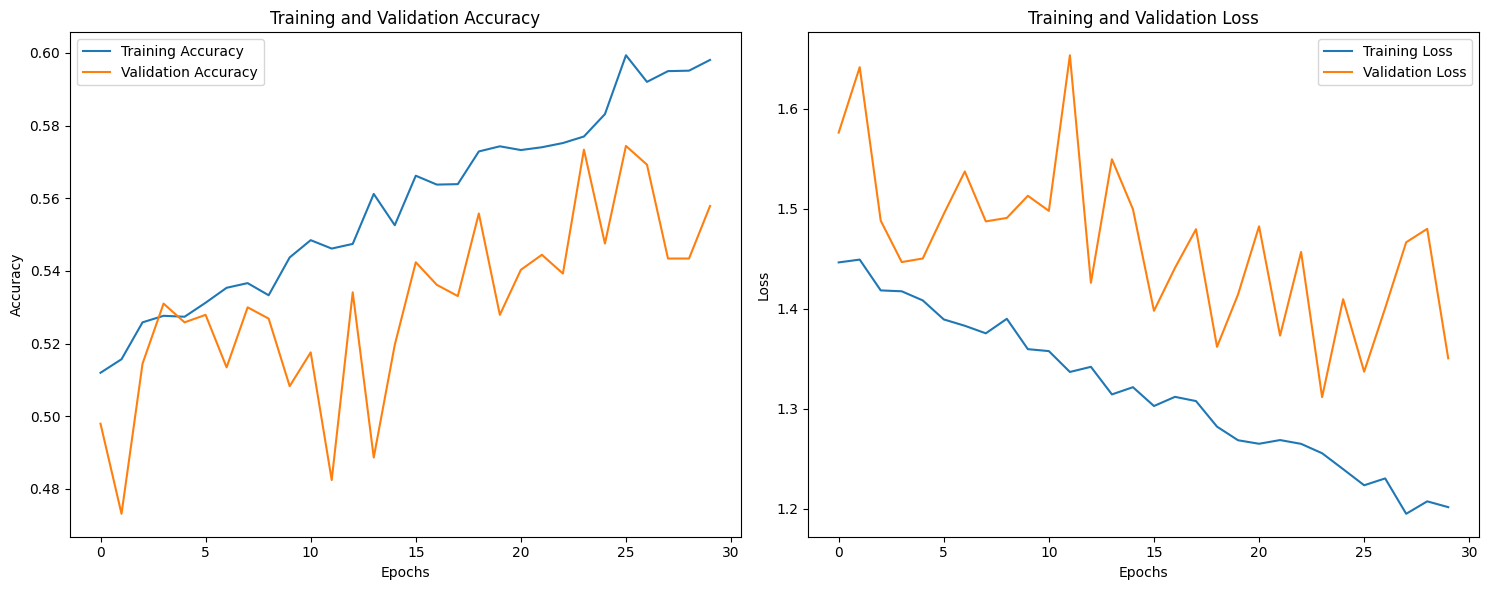

In [ ]:
# sudah ditambah 6 augmen | Adam | lr 1e-3 | 32 64 128 AvgGlobal 128
plot_loss_acc(history)

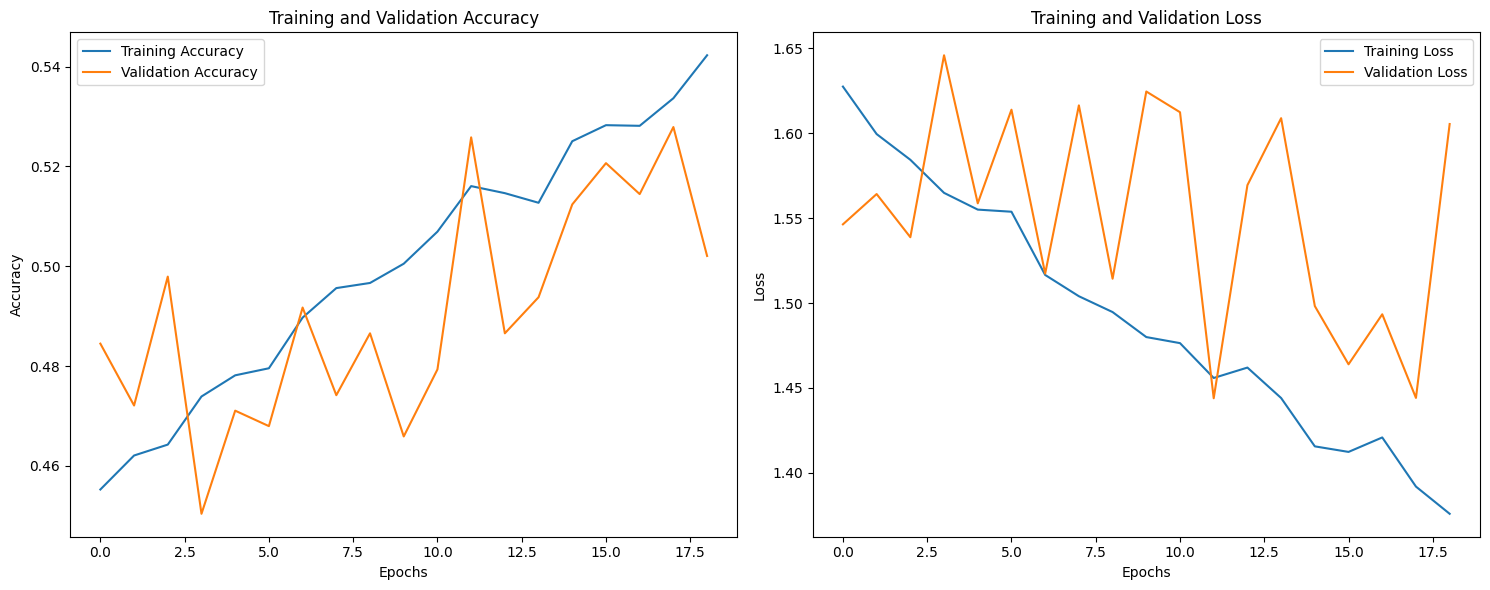

In [ ]:
# sudah ditambah 6 augmen | Adam | lr 1e-3 | 32 64 128 AvgGlobal 128
plot_loss_acc(history)

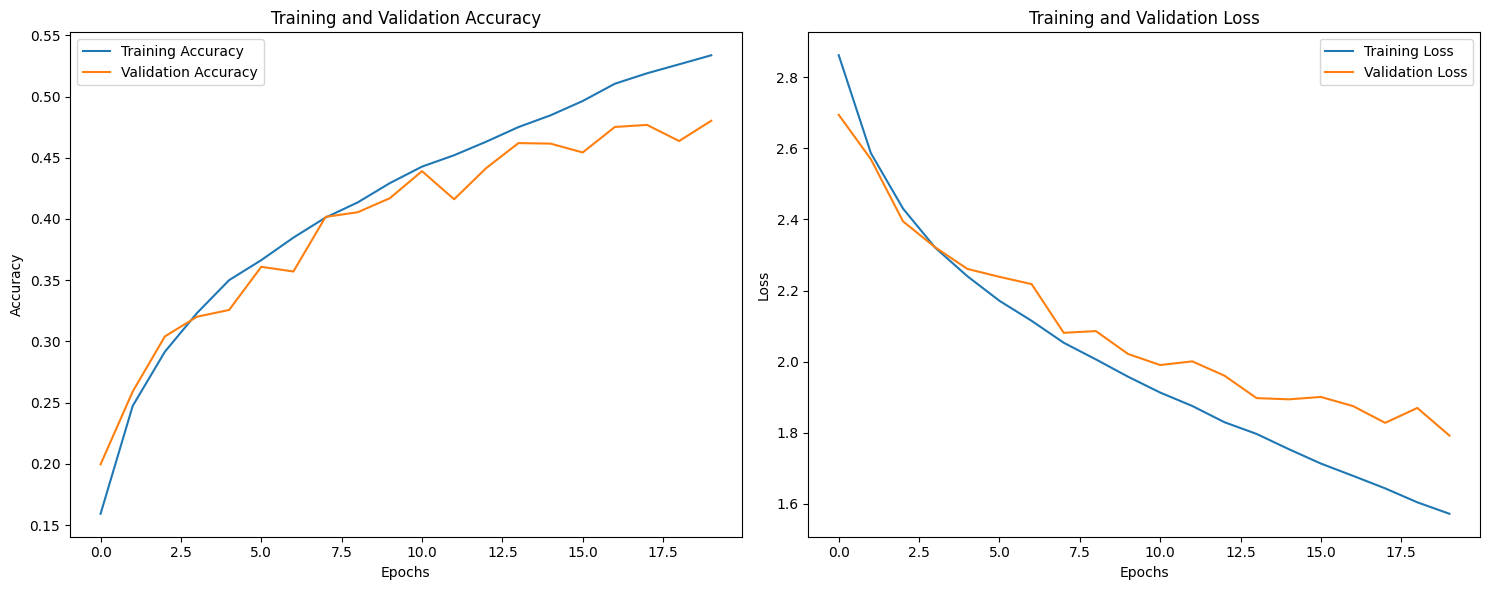

In [ ]:
plot_loss_acc(history)

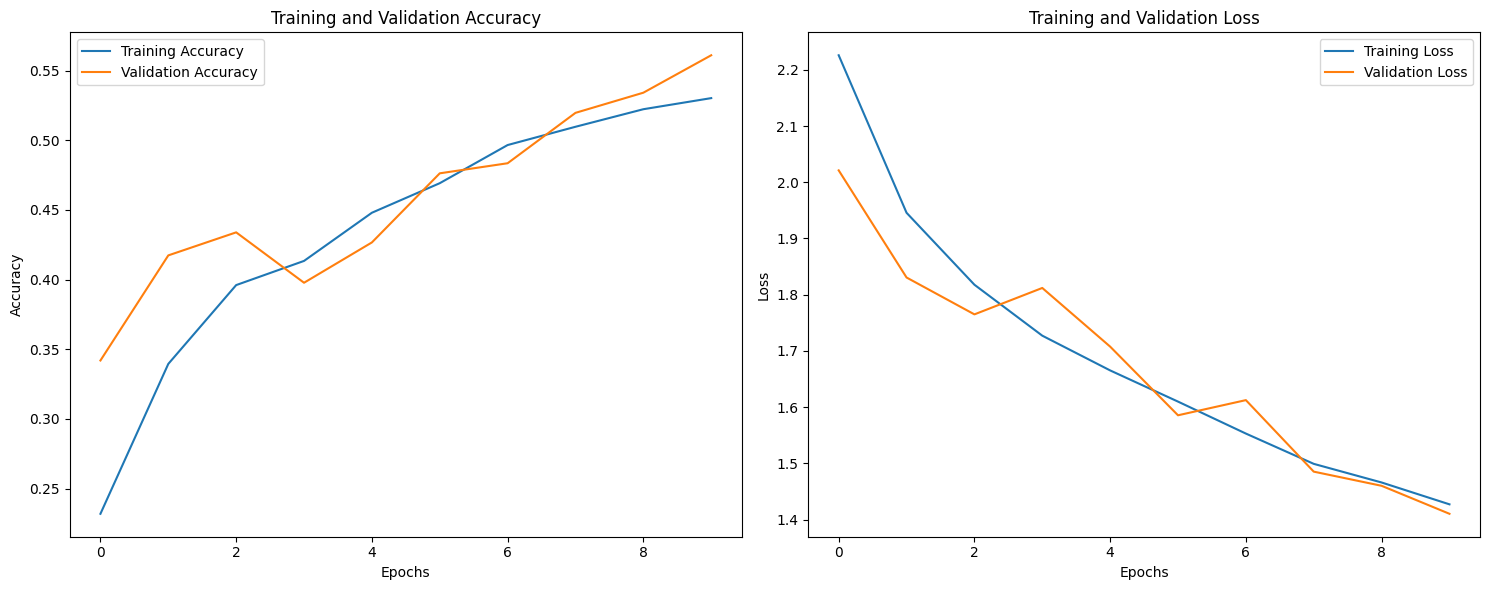

In [ ]:
# rmsProp 5 10-4 . 32 64 128 | 512
plot_loss_acc(history)

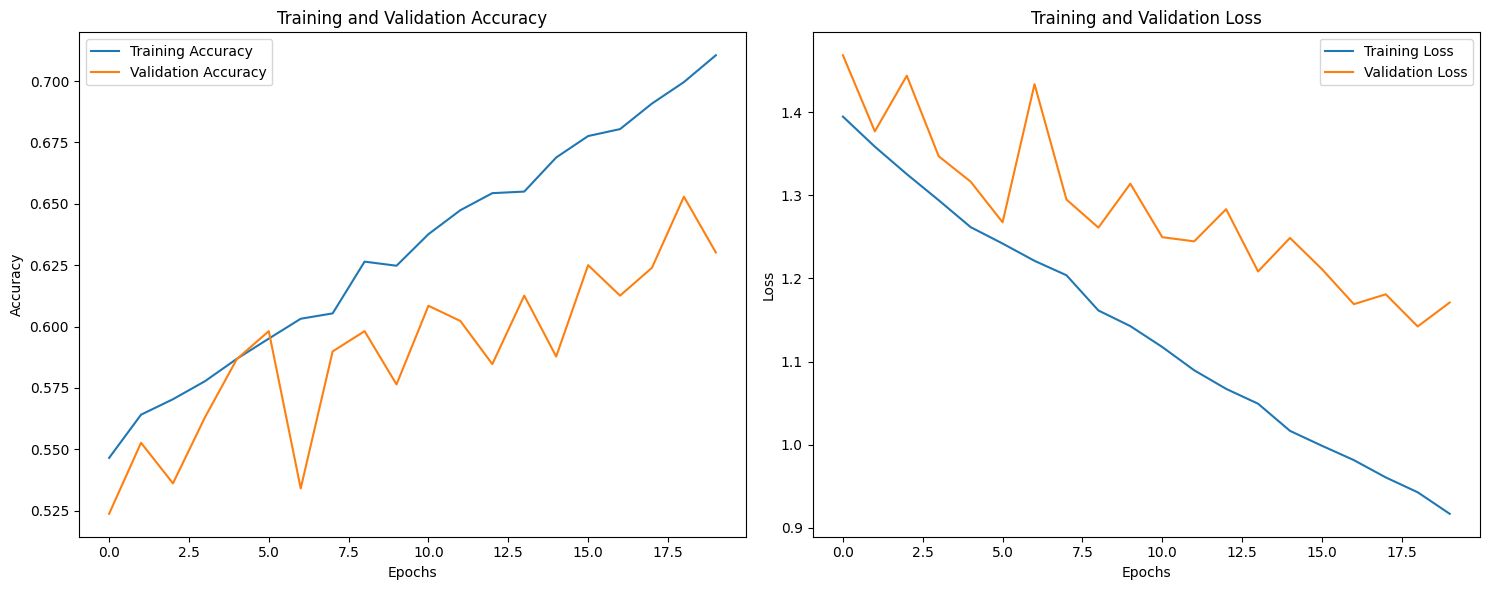

In [ ]:
# rmsProp 5 10-4 . 32 64 128 | 512 | epoch 20
plot_loss_acc(history)

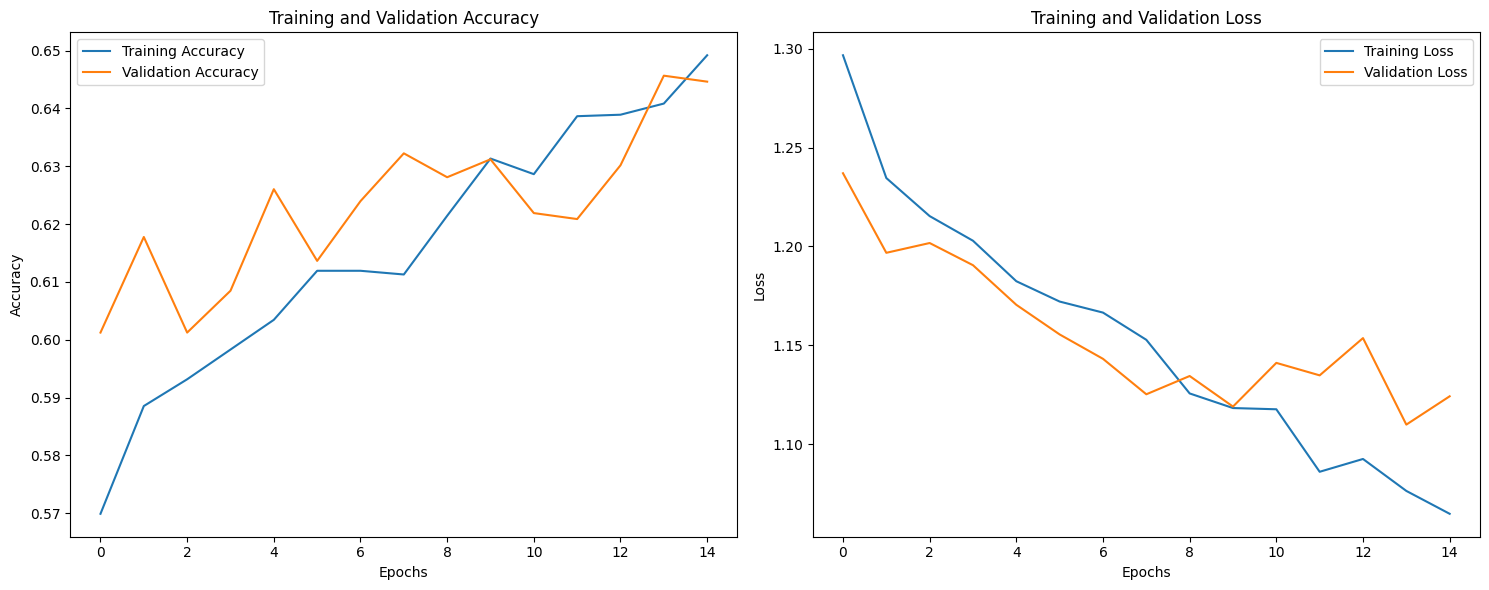

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.8 lr=85-10-4 | 32 64 128 | 512 | epoch 15
plot_loss_acc(history)

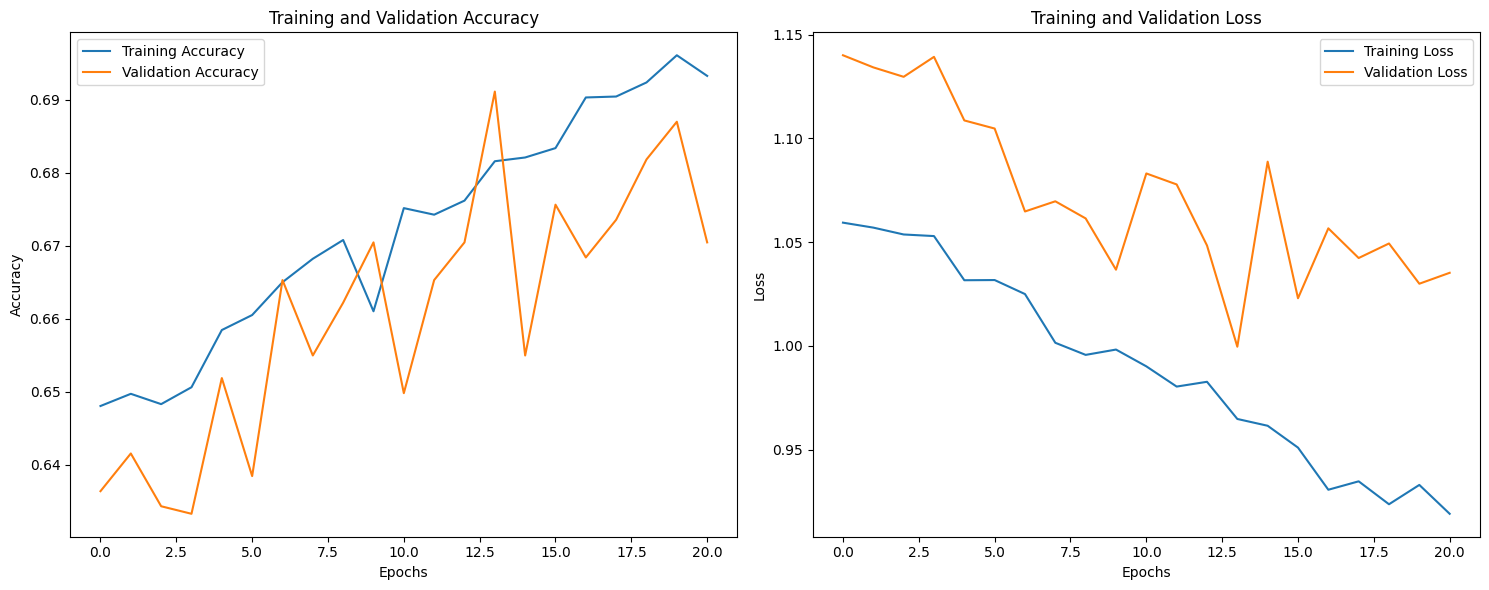

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.8 lr=85-10-4 | 32 64 128 | 512 | epoch 21
plot_loss_acc(history)

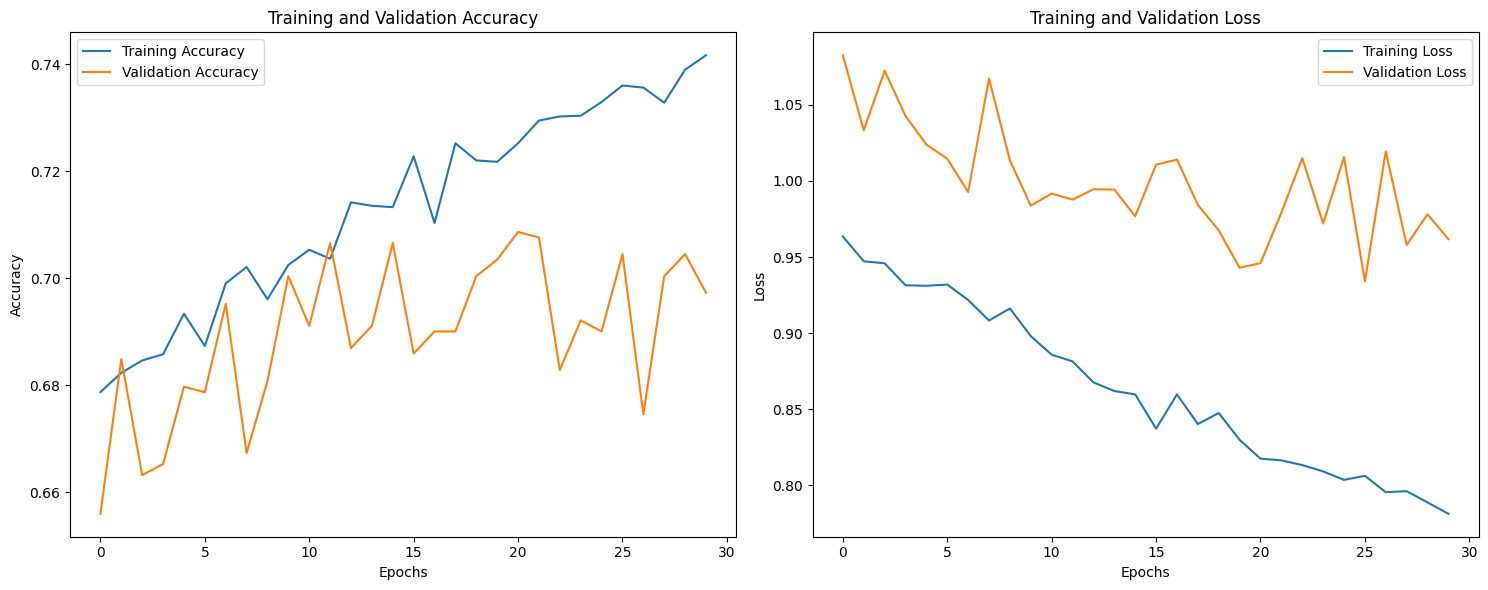

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.9 lr=85-10-4 | 32 64 128 | 512 | epoch 30
plot_loss_acc(history)

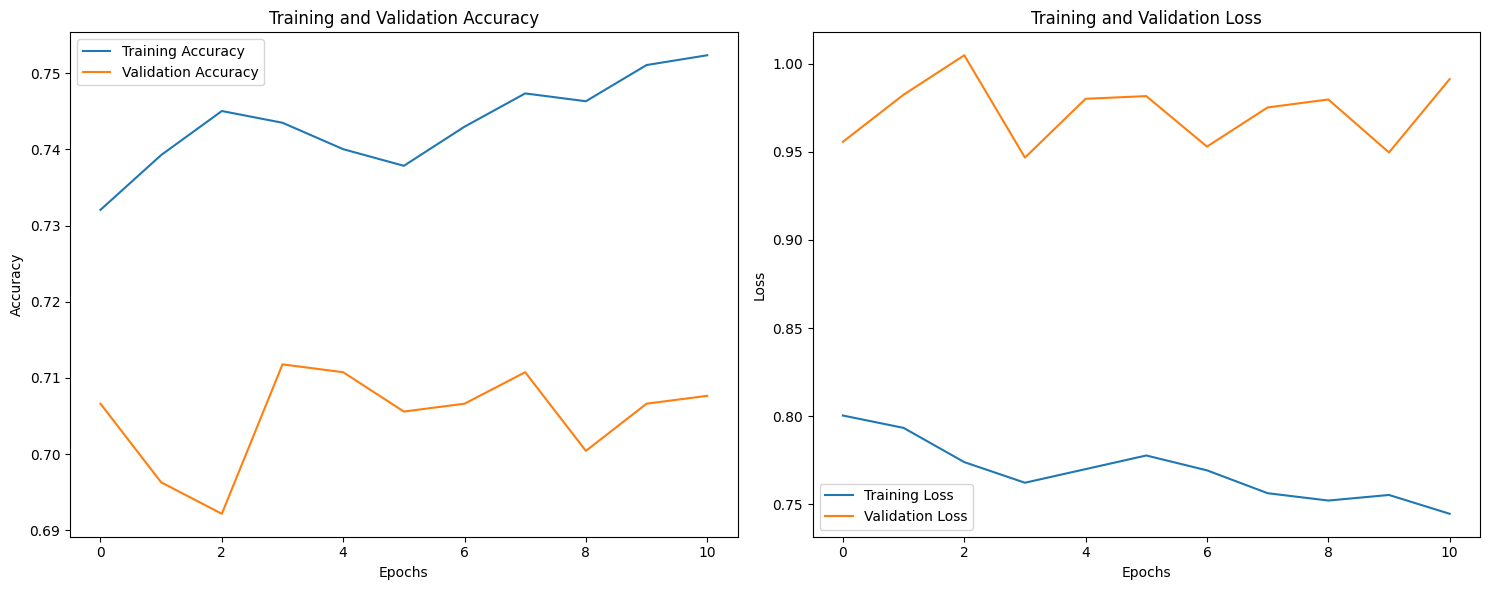

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.9 lr=8e-4 | 32 64 128 | 512 | epoch 21
plot_loss_acc(history)

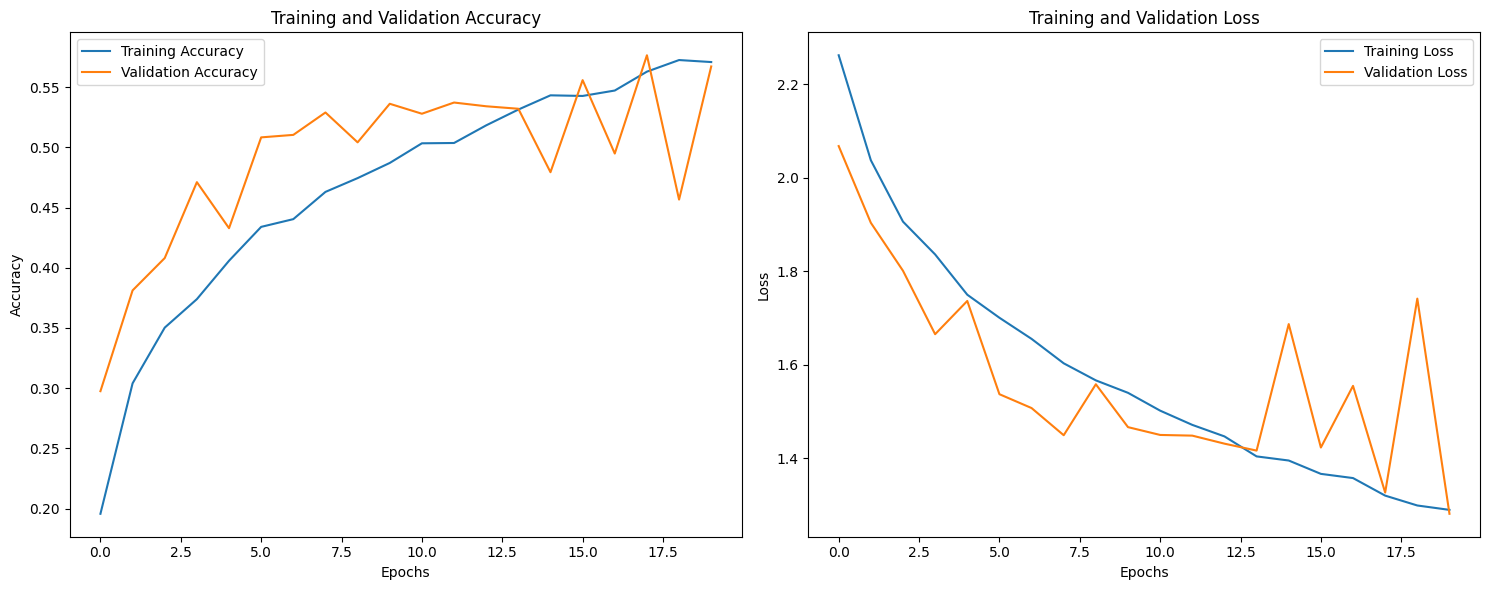

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.9 lr=85e-4 | 32 64 128 256 | 512 |
plot_loss_acc(history)

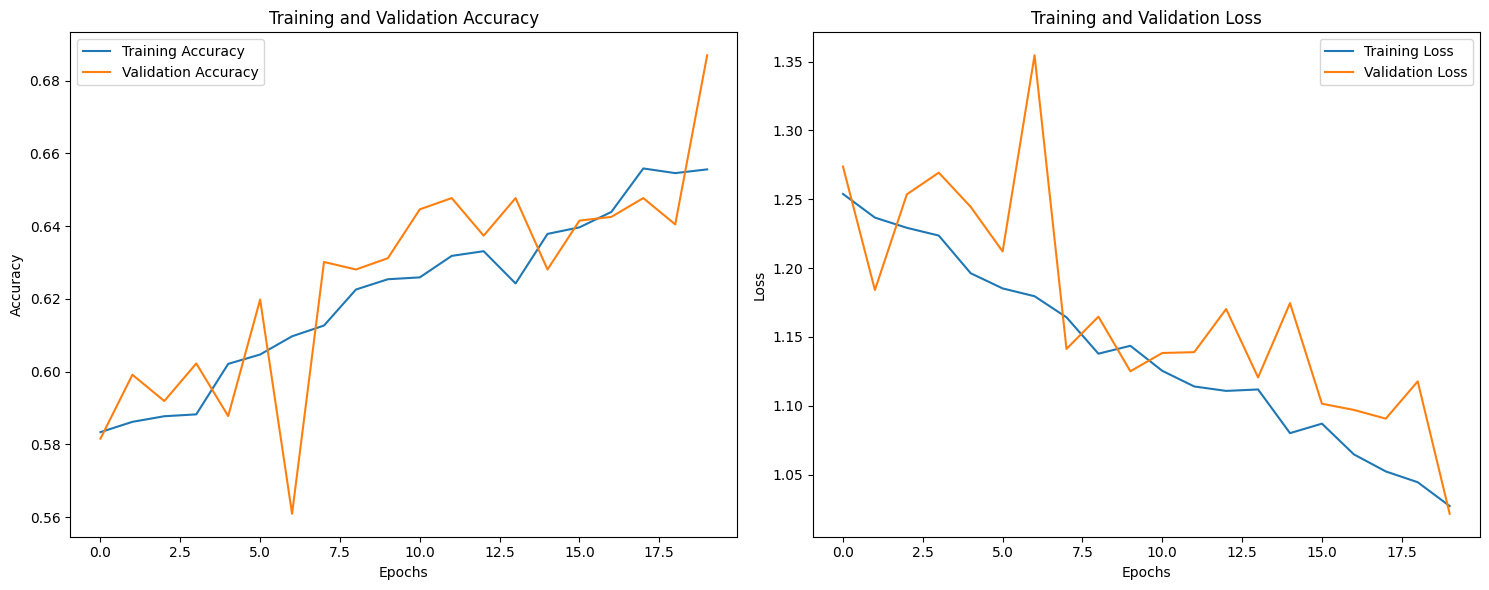

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.7 lr=85e-4 | 32 64 128 256 | 512 |
plot_loss_acc(history)

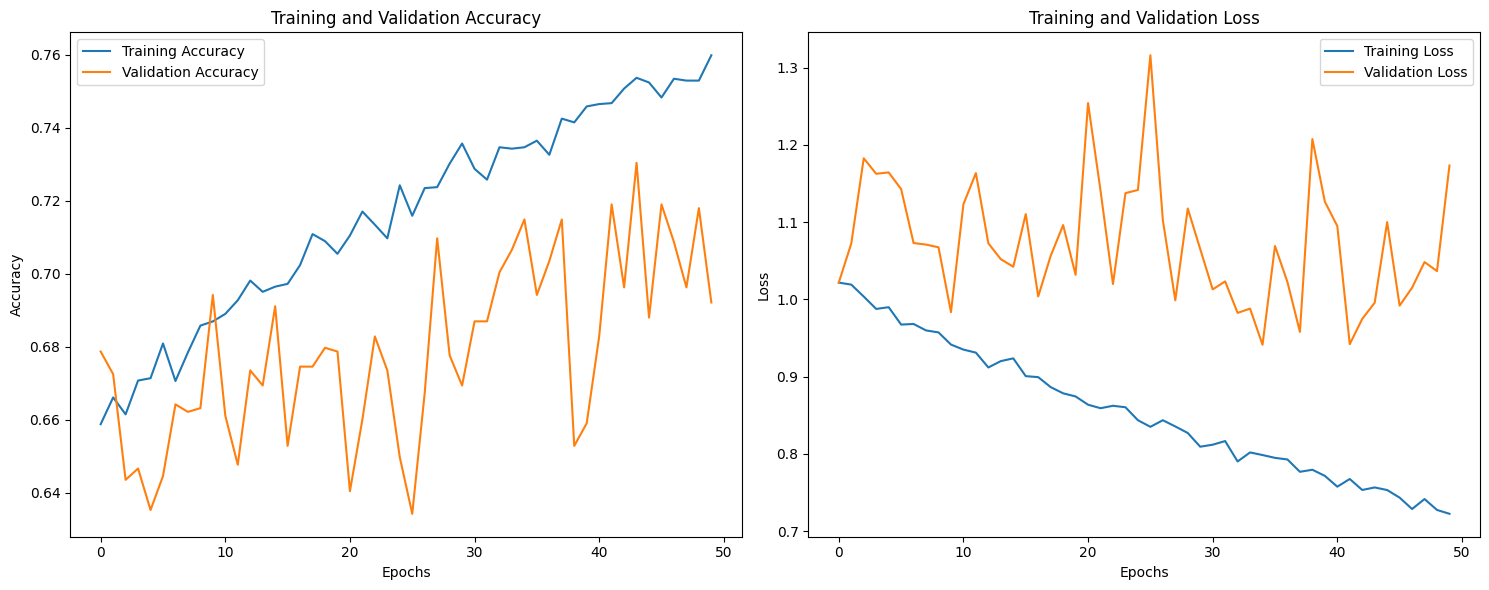

In [ ]:
# tambah augmentasi 3 | rmsProp rho=0.7 lr=85e-4 | 32 64 128 256 | 512 |
plot_loss_acc(history)

In [ ]:
# tambah augmentasi 3 | Adam lr=85e-4 | 32 64 128 | 512 |
plot_loss_acc(history)